# Model Visualizers

In [1]:
# import pyvista as pv
# pv.Plotter?

# import mne
# Brain = mne.viz.get_brain_class()
#brain = Brain('fsaverage')

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from neurodsp.sim import sim_powerlaw, sim_combined
from neurodsp.spectral import compute_spectrum, trim_spectrum
from neurodsp.plts.utils import check_ax

from fooof import FOOOF, Bands
from fooof.sim.gen import gen_aperiodic
from fooof.plts.fm import _add_peaks_shade
from fooof.analysis import get_band_peak_fm

In [3]:
# Import local code
from vcode.utils.data import yield_sig
from vcode.plts.utils import clear_output, animate_plot
from vcode.plts.timeseries import plot_timeseries, plot_spectra

In [4]:
import seaborn as sns
sns.set_context('talk')

In [5]:
from matplotlib import rc
rc('font',**{'family':'serif', 'serif':['Times']})
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
#rc('text', usetex=True)

## Settings

In [6]:
BANDS = Bands({
    'delta' : [1, 4],
    'theta' : [4, 8],
    'alpha' : [8, 13],
    'beta' : [13, 30],
    'gamma' : [30, 50]
})

COLORS = {'delta' : '#e8dc35',
          'theta' : '#46b870',
          'alpha' : '#1882d9',
          'beta'  : '#a218d9',
          'gamma' : '#e60026'}

LABELS = {
    'delta' : r'$\delta$',
    'theta' : r'$\theta$',
    'alpha' : r'$\alpha$',
    'beta'  : r'$\beta$',
    'gamma' : r'$\gamma$'
}

In [7]:
F_RANGE = [2, 50]

In [8]:
N_SECONDS = 30
FS = 500

## Helper Functions

In [9]:
def find_nearest_ind(array, value):
    return np.abs(array-value).argmin()

def compute_abs_power(freqs, powers, band):
    """Compute absolute power for a given frequency band."""

    _, band_powers = trim_spectrum(freqs, powers, band)
    avg_power = np.sum(band_powers)

    return avg_power

def get_features(model, freqs, powers):
    
    funcs = {
        'freq' : get_features_freq,
        'band' : get_features_band,
        'peap' : get_features_peap,
    }
    
    return funcs[model](freqs, powers)

def get_features_freq(freqs, powers):

    extract = np.array([5, 10, 15, 20, 25])
    values = [powers[find_nearest_ind(freqs, freq)] for freq in extract]
    
    c1 = ['freq-{}'.format(val) for val in extract]
    c2 = ['{:1.3f}'.format(val) for val in values]
    col_data = [[a, b] for a, b in zip(c1, c2)]

    return col_data

def get_features_band(freqs, powers):
    
    powers = [compute_abs_power(freqs, powers, band) for band in BANDS.definitions]
    powers = ['{:1.3f}'.format(val) for val in powers]
    col_data = [[a, b] for a, b in zip(LABELS.values(), powers)]

    return col_data

def fit_specparam(freqs, powers):
    
    fm = FOOOF(min_peak_height=0.35, verbose=False)
    fm.fit(freqs, powers)

    return fm

def get_features_peap(freqs, powers):
    
    exp = FM.get_params('aperiodic', 'exponent')
    off = FM.get_params('aperiodic', 'offset')
    
    alpha = get_band_peak_fm(FM, [8, 13])
    if np.isnan(alpha[0]):
        alpha = [0, 0, 0, ]
    cf, pw, bw = alpha
    
    labels = ['ap-exp', 'ap-off', r'$\alpha$-cf', r'$\alpha$-pw', r'$\alpha$-bw']    
    values = ['{:1.3f}'.format(val) for val in [exp, off, cf, pw, bw]]
    
    col_data = [[a, b] for a, b in zip(labels, values)]
    
    return col_data

## Plot Functions

In [10]:
def plot_model_spectrum(model, freqs, powers, ax, **kwargs):
    
    funcs = {
        'freq' : plot_spectra_freq,
        'band' : plot_spectra_band,
        'peap' : plot_spectra_peap
    }
    
    funcs[model](freqs, powers, **kwargs, ax=ax)

def plot_spectra_freq(freqs, powers, ax=None):

    ax = check_ax(ax)
    plot_spectra(freqs, powers,
                 marker='.', linestyle="",
                 xlim=F_RANGE, colors='black',
                 ax=ax)

def plot_spectra_band(freqs, powers, ax=None):
    
    ax = check_ax(ax)
    plot_spectra(freqs, powers,
                 shade_ranges=BANDS.definitions,
                 shade_colors=list(COLORS.values()), 
                 xlim=F_RANGE, colors='black', alpha=0.75,
                 ax=ax)

def plot_spectra_peap(freqs, powers, ax=None):
    
    ax = check_ax(ax)
    plot_spectra(freqs, powers,
                 xlim=F_RANGE, colors='black', alpha=0.75,
                 ax=ax)
    
    ap_fit = gen_aperiodic(freqs, FM.aperiodic_params_)
    #ax.plot(np.log10(freqs), FM.fooofed_spectrum_, color='red', alpha=0.5)
    ax.plot(np.log10(freqs), ap_fit, '--', c='blue', lw=2.5, alpha=0.75)
    if FM.n_peaks_:
        _add_peaks_shade(FM, True, ax)

In [11]:
def plot_table(table_data, ax=None):
    
    ax = check_ax(ax)

    table = plt.table(table_data, colWidths=[0.5, 0.5],
                      loc='center', cellLoc='center')
    table.set_fontsize(18)
    table.scale(1, 3)
    ax.axis('off')
    
def _add_model_text(model, ax=None):

    ax = check_ax(ax)
    fontdict = {'fontsize' : 18}
    
    texts = {
        'freq' : 'Frequency\nby\nFrequency',
        'band' : 'Band\nby\nBand',
        'peap' : 'Periodic\n&\nAperiodic'
    }
    
    ax.text(0.5, 0.85, "Model:",
            fontdict=fontdict, ha='center')
    ax.text(0.5, 0.35, texts[model],
             fontdict=fontdict, ha='center')
    ax.axis('off')

In [12]:
def make_axes():
    """Make axes for combined plot.
    
    Notes:
    Placement definitions: Left, Bottom, Width, Height
    """
    
    fig = plt.figure()
    ax1 = fig.add_axes([0.0, 1.1, 0.4, 0.5]) 
    ax2 = fig.add_axes([0.5, 1.3, 1., 0.3]) 

    ax3 = fig.add_axes([0.0, 0.5, 0.4, 0.5])
    ax4 = fig.add_axes([0.5, 0.5, 0.6, 0.65])
    ax5 = fig.add_axes([1.2, 0.5, 0.3, 0.65])
        
    return fig, [ax1, ax2, ax3, ax4, ax5]

## Simulate Signals

In [13]:
sig = sim_powerlaw(N_SECONDS, FS, -1.25, f_range=(0.5, None))

In [14]:
comp_vars = [0.5, 1]
#comps = {'sim_powerlaw' : {'exponent' : -1.25, 'f_range' : (0.5, None)},
#         'sim_oscillation' : {'freq' : 10}}

comps = {'sim_powerlaw' : {'exponent' : -1.25, 'f_range' : (0.5, None)},
         'sim_bursty_oscillation' : {'freq' : 10}}

In [15]:
sig = sim_combined(N_SECONDS, FS, comps, comp_vars)

## Make Example Image

Text(0.5, 1.0, 'Features')

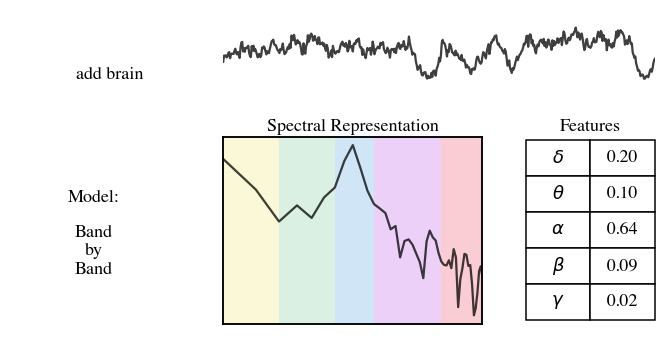

In [16]:
#MODEL = 'freq'
MODEL = 'band'
#MODEL = 'peap'

fig, axes = make_axes()

# Compute needed things
freqs, powers = trim_spectrum(*compute_spectrum(sig[0:1000], fs=FS), F_RANGE)

if MODEL == 'peap':
    FM = fit_specparam(freqs, powers)

# Axis 0
axes[0].text(0.4, 0.5, 'add brain')
axes[0].axis('off')

# Axis 1
plot_timeseries(sig, colors='black', alpha=0.75, ax=axes[1], xlim=[0, 500])
axes[1].axis('off')

# Axis 2
_add_model_text(MODEL, ax=axes[2])

# Axis 3
plot_model_spectrum(MODEL, freqs, powers, ax=axes[3])
axes[3].set_title('Spectral Representation')

# Axis 4
table_data = get_features(MODEL, freqs, powers)
plot_table(table_data, ax=axes[4])
axes[4].set_title('Features')

## Build Function

In [17]:
#MODEL = 'freq'
MODEL = 'band'
#MODEL = 'peap'

In [18]:
def build_all(sig, n_build=np.inf, sleep=0.05, label='viz', save=False):
    """Build all plots together."""

    size = 500
    step = 2
    start = 2000

    sig_yielder = yield_sig(sig, start=start, size=size, step=step)

    for ind in range(n_build):

        clear_output(wait=True)

        fig, axes = make_axes()

        # Compute needed things
        spect_sig = sig[start + step * ind-2000:start + step * ind+2000]
        freqs, powers = trim_spectrum(*compute_spectrum(spect_sig, fs=FS), F_RANGE)

        if MODEL == 'peap':
            global FM
            FM = fit_specparam(freqs, powers)

        # Axis 0
        axes[0].text(0.4, 0.5, 'add brain')
        axes[0].axis('off')

        # Axis 1
        plot_timeseries(next(sig_yielder), colors='black',
                        alpha=0.75, ax=axes[1])
        axes[1].axis('off')

        # Axis 2
        _add_model_text(MODEL, ax=axes[2])

        # Axis 3
        plot_model_spectrum(MODEL, freqs, powers, ax=axes[3])
        axes[3].set_title('Spectral Representation')

        # Axis 4
        #table_data = get_features_freq()
        table_data = get_features(MODEL, freqs, powers)
        plot_table(table_data, ax=axes[4])
        axes[4].set_title('Features')

        animate_plot(fig, save, ind, label=label, sleep=sleep)

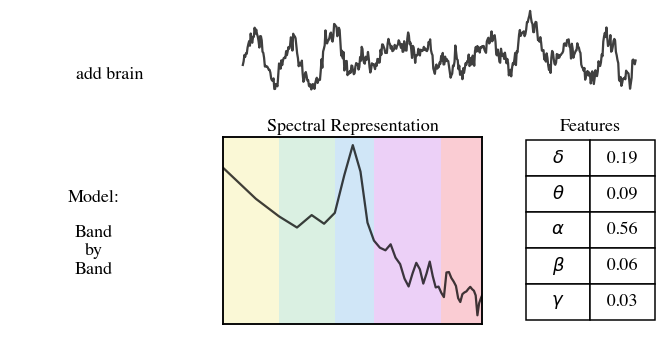

In [19]:
build_all(sig, n_build=50)

## zMISC / EXTRA

In [22]:
table_data=[
    ["f1", 10],
    ["f2", 20],
    ["f3", 30],
    ["f4", 0.6],
    ["f5", 0.4]
]

table_data=[
    [r'$\delta$', 10],
    [r'$\theta$', 20],
    [r'$\alpha$', 30],
    [r'$\beta$', 0.6],
    [r'$\gamma$', 0.4]
]

table_data=[
    ['ap-exp', 10],
    ['ap-off', 20],
    [r'$\alpha$-cf', 30],
    [r'$\alpha$-pw', 0.6],
    [r'$\alpha$-bw', 0.4]
]

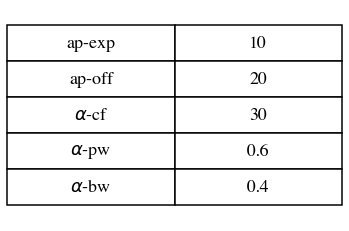

In [23]:
plot_table(table_data)